In [48]:
#there were several concepts that I was new to, including the Panda's operation to replace NaN's as well as memory reduction.
#Kartik Athale shared some code, so I am employing some of his code here.
#as the main goal is to best fit the data, I will mainly be targeting on attempting to improve fit of the LogisticRegression model by 
#analyzing sensitivity to error tolerance.

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import math
from copy import deepcopy
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Read the CSV file
train_xact = pd.read_csv('data/train_transaction.csv')
test_xact = pd.read_csv('data/test_transaction.csv')
train_ident = pd.read_csv('data/train_identity.csv')
test_ident = pd.read_csv('data/test_identity.csv')

train= pd.merge(train_xact,train_ident,how="left",on="TransactionID")
test = pd.merge(test_xact,test_ident,how="left",on="TransactionID")


In [3]:
print('data loaded...')

data loaded...


In [4]:
#all credit to Kartik Athale (https://www.kaggle.com/kartikathale/fraud-detection-eda-basic-logistic-regression)


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

del train_xact
del test_xact
del train_ident
del test_ident


train_bkp = train.copy()
test_bkp = test.copy()

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [5]:
print('memory reduction complete')

memory reduction complete


In [6]:
train = train_bkp.copy()
test = test_bkp.copy()

In [7]:
#split training targets and data.  remove transaction ID from training and split isFraud to represent the 'y' vector.

train_y = train['isFraud']

train = train.drop(['isFraud','TransactionID'], axis=1)
test = test.drop(['TransactionID'], axis = 1)

In [8]:
#preprocessing (docs appear to describe one-hot encoding: taking training and test data field which are non-numeric and encoding a number to show if being used).

for f in train.columns:
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))


In [9]:
train_bkp2 = train.copy()
test_bkp2 = test.copy()

In [10]:
### remove crap columns.  Fill NaNs and infs  
#more credit to Kartik

null_percent = train.isnull().sum()/train.shape[0]*100
cols_to_drop = np.array(null_percent[null_percent > 50].index)

def trimandfillnanandinfs(df, cols_to_drop):
    df = df.drop(cols_to_drop, axis=1)
    df = df.fillna(-999)
    df = df.replace([np.inf, -np.inf], -999)
    return df

train = trimandfillnanandinfs(train, cols_to_drop)
test = trimandfillnanandinfs(test, cols_to_drop)
print(cols_to_drop)

['dist1' 'dist2' 'D5' 'D6' 'D7' 'D8' 'D9' 'D12' 'D13' 'D14' 'V138' 'V139'
 'V140' 'V141' 'V142' 'V143' 'V144' 'V145' 'V146' 'V147' 'V148' 'V149'
 'V150' 'V151' 'V152' 'V153' 'V154' 'V155' 'V156' 'V157' 'V158' 'V159'
 'V160' 'V161' 'V162' 'V163' 'V164' 'V165' 'V166' 'V167' 'V168' 'V169'
 'V170' 'V171' 'V172' 'V173' 'V174' 'V175' 'V176' 'V177' 'V178' 'V179'
 'V180' 'V181' 'V182' 'V183' 'V184' 'V185' 'V186' 'V187' 'V188' 'V189'
 'V190' 'V191' 'V192' 'V193' 'V194' 'V195' 'V196' 'V197' 'V198' 'V199'
 'V200' 'V201' 'V202' 'V203' 'V204' 'V205' 'V206' 'V207' 'V208' 'V209'
 'V210' 'V211' 'V212' 'V213' 'V214' 'V215' 'V216' 'V217' 'V218' 'V219'
 'V220' 'V221' 'V222' 'V223' 'V224' 'V225' 'V226' 'V227' 'V228' 'V229'
 'V230' 'V231' 'V232' 'V233' 'V234' 'V235' 'V236' 'V237' 'V238' 'V239'
 'V240' 'V241' 'V242' 'V243' 'V244' 'V245' 'V246' 'V247' 'V248' 'V249'
 'V250' 'V251' 'V252' 'V253' 'V254' 'V255' 'V256' 'V257' 'V258' 'V259'
 'V260' 'V261' 'V262' 'V263' 'V264' 'V265' 'V266' 'V267' 'V268' 'V269'
 'V

In [11]:
#unsure the benefit of scaling int values.  it may improve things, but I'm omitting them from this method

#https://www.data-blogger.com/2017/06/15/fraud-detection-a-simple-machine-learning-approach/

#wolud love to normalize data, but keep getting "NaNs" for means

# def normalize(df):
    
    
#     floats = ['float16', 'float32', 'float64']
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in floats:
#             print(col, df[col].mean(), df[col].std())
# #             df[col] -= df[col].mean()
# #             df[col] /= df[col].std()

#     return df

# train = normalize(train)
# print('_____')
# test = normalize(test)

In [12]:
train_X = train.copy()
test_X = test.copy()
test_y = np.ones(test_X.shape[0])


In [13]:
print(train_y.head())

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int8


In [14]:
sns.set(style="darkgrid")
train_viz= train.copy()
fraudarr = np.asarray(train_y)
train_viz['isFraud'] = fraudarr


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


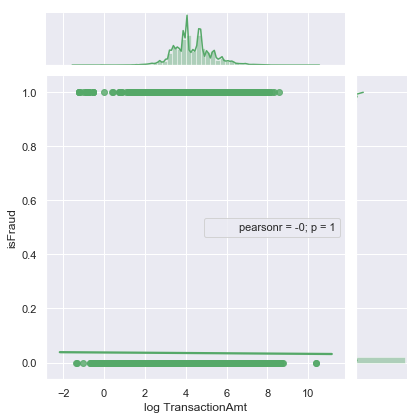

time to plot:  0:01:37.580084


In [49]:
t0 = datetime.now()
#taking log because of large range of data values.
train_viz['log TransactionAmt'] = np.log(train_viz['TransactionAmt'])

sns.set(style="darkgrid", color_codes=True)
j = sns.jointplot(data=train_viz, x='log TransactionAmt', y='isFraud', color='g', kind='reg')
j.annotate(stats.pearsonr)
plt.show()

print('time to plot:  {}'.format(datetime.now() - t0))

In [50]:
#Visually and statistically, there appears to be no correlation between Transaction amount and fraudulent transactions.
#This was also (frustratingly) the case for any other single variable that I tested against 'isFraud'.

In [18]:
mses = []
models = []

for tol_mag in range(3,11):
    print("new model")
    t0 = datetime.now()
    model = LogisticRegression(tol=10**-tol_mag)
    print("time to instantiate: ", datetime.now()-t0)
    t1 = datetime.now()
    model.fit(train_X, train_y)
    t2 = datetime.now()
    print("time to fit: ", t2-t1)
    pred = model.predict(test_X)
    print("time to predict: ", datetime.now()-t2)
    mse = mean_squared_error(test_y, pred)
    print(tol_mag, mse)
    mses.append(mse)
    models.append(deepcopy(model))




new model
time to instantiate:  0:00:00.000998


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


time to fit:  0:00:27.759612
time to predict:  0:00:02.441821
3 0.9999625018009004
new model
time to instantiate:  0:00:00


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


time to fit:  0:01:27.611259
time to predict:  0:00:01.081120
4 0.9994296326558001
new model
time to instantiate:  0:00:00


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


time to fit:  0:03:19.027142
time to predict:  0:00:01.266751
5 0.9982217959269062
new model
time to instantiate:  0:00:00


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


time to fit:  0:03:19.777223
time to predict:  0:00:01.491317
6 0.9982217959269062
new model
time to instantiate:  0:00:00


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


time to fit:  0:03:08.976459
time to predict:  0:00:01.048712
7 0.9982217959269062
new model
time to instantiate:  0:00:00


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


time to fit:  0:02:46.569757
time to predict:  0:00:00.991697
8 0.9982217959269062
new model
time to instantiate:  0:00:00


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


time to fit:  0:03:05.289760
time to predict:  0:00:01.194812
9 0.9982217959269062
new model
time to instantiate:  0:00:00.000999


c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\u773253\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


time to fit:  0:02:44.360743
time to predict:  0:00:00.989360
10 0.9982217959269062


In [21]:
minmseidx = 0
for idx in range(1, len(mses)):
    if mses[idx] < mses[minmseidx]:
        minmseidx = idx
bestmodel = models[minmseidx]

In [24]:
print("best fit based on control of error tolerance is to employ tol = 10**-{}.".format(minmseidx+3))

best fit based on control of error tolerance is to employ tol = 10**-5.
